# CLASSIFY GERMAN TRAFFIC SIGNS USING LE-NET ARCHITECTURE IN KERAS

# PROBLEM STATEMENT
- The dataset contains 43 different classes of images. 
Classes are as listed below: 
- ( 0, b'Speed limit (20km/h)') ( 1, b'Speed limit (30km/h)')
- ( 2, b'Speed limit (50km/h)') ( 3, b'Speed limit (60km/h)')
- ( 4, b'Speed limit (70km/h)') ( 5, b'Speed limit (80km/h)')
- ( 6, b'End of speed limit (80km/h)') ( 7, b'Speed limit (100km/h)')
- ( 8, b'Speed limit (120km/h)') ( 9, b'No passing')
- (10, b'No passing for vehicles over 3.5 metric tons')
- (11, b'Right-of-way at the next intersection') (12, b'Priority road')
- (13, b'Yield') (14, b'Stop') (15, b'No vehicles')
- (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
- (18, b'General caution') (19, b'Dangerous curve to the left')
- (20, b'Dangerous curve to the right') (21, b'Double curve')
- (22, b'Bumpy road') (23, b'Slippery road')
- (24, b'Road narrows on the right') (25, b'Road work')
- (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
- (29, b'Bicycles crossing') (30, b'Beware of ice/snow')
- (31, b'Wild animals crossing')
- (32, b'End of all speed and passing limits') (33, b'Turn right ahead')
- (34, b'Turn left ahead') (35, b'Ahead only') (36, b'Go straight or right')
- (37, b'Go straight or left') (38, b'Keep right') (39, b'Keep left')
- (40, b'Roundabout mandatory') (41, b'End of no passing')
- (42, b'End of no passing by vehicles over 3.5 metric tons')

The network used is called Le-Net that was presented by Yann LeCun 
http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf   

In [1]:
# STEP 1: IMPORT LIBRARIES AND DATASET
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
import pickle
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure.
with open("./traffic-signs-data/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("./traffic-signs-data/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("./traffic-signs-data/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_validation shape:', X_validation.shape)
print('y_validation shape:', y_validation.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to number of labels"
assert(X_validation.shape[0] == y_validation.shape[0]), "The number of images is not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_validation.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_validation shape: (4410, 32, 32, 3)
y_validation shape: (4410,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


31

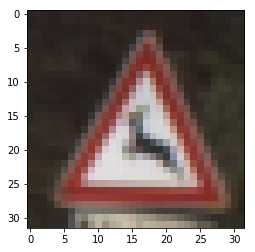

In [3]:
# STEP 2: IMAGE EXPLORATION
i = 500
plt.imshow(X_train[i]) # Show images are not shuffled
y_train[i]

In [4]:
# STEP 3: DATA PEPARATION
## Shuffle the dataset 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_test_gray  = np.sum(X_test/3, axis=3, keepdims=True)
X_validation_gray  = np.sum(X_validation/3, axis=3, keepdims=True) 

X_train_gray_norm = (X_train_gray - 128)/128 
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray - 128)/128

print('X_train_gray shape:', X_train_gray.shape)
print('X_test_gray shape:', X_test_gray.shape)
print('X_validation_gray shape:', X_validation_gray.shape)
print('X_train_gray_norm shape:', X_train_gray_norm.shape)
print('X_test_gray_norm shape:', X_test_gray_norm.shape)
print('X_validation_gray_norm shape:', X_validation_gray_norm.shape)

X_train_gray shape: (34799, 32, 32, 1)
X_test_gray shape: (12630, 32, 32, 1)
X_validation_gray shape: (4410, 32, 32, 1)
X_train_gray_norm shape: (34799, 32, 32, 1)
X_test_gray_norm shape: (12630, 32, 32, 1)
X_validation_gray_norm shape: (4410, 32, 32, 1)


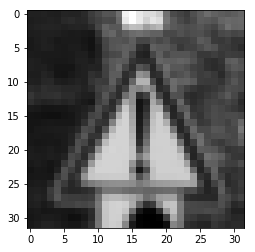

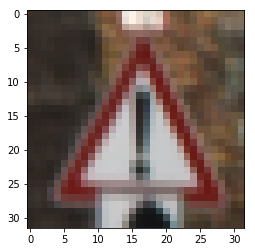

In [5]:
i = 610
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])


# MODEL TRAINING

In [6]:
image_shape = X_train_gray[i].shape

cnn_model = Sequential()
cnn_model.add(Conv2D(32,3, 3, input_shape = image_shape, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(output_dim = 32, activation = 'relu'))
cnn_model.add(Dense(output_dim = 43, activation = 'sigmoid'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

history = cnn_model.fit(X_train_gray_norm, y_train, batch_size=500, nb_epoch=40, verbose=1,
                        validation_data = (X_validation_gray_norm,y_validation))

score = cnn_model.evaluate(X_test_gray_norm, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))




Instructions for updating:
Colocations handled automatically by placer.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 1..., activation="relu")`
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32)`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=43)`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 34799 samples, validate on 4410 samples
Epoch 1/40
34799/34799 [==============================] - 17s 496us/step - loss: 3.3628 - accuracy: 0.0745 - val_loss: 3.2480 - val_accuracy: 0.0816
Epoch 2/40
34799/34799 [==============================] - 17s 483us/step - loss: 2.1604 - accuracy: 0.3777 - val_loss: 1.9835 - val_accuracy: 0.4508
Epoch 3/40
34799/34799 [==============================] - 17s 485us/step - loss: 1.2501 - accuracy: 0.6734 - val_loss: 1.4801 - val_accuracy: 0.6091
Epoch 4/40
34799/34799 [==============================] - 17s 481us/step - loss: 0.9363 - accuracy: 0.7591 - val_loss: 1.2197 - val_accuracy: 0.6927
Epoch 5/40
34799/34799 [==============================] - 17s 488us/step - loss: 0.7435 - accuracy: 0.8202 - val_loss: 1.0784 - val_accuracy: 0.7166
Epoch 6/40
34799/34799 [==============================] - 17s 486us/step - loss: 0.6329 - accuracy: 0.8488 - val_loss: 1.0157 - val_accuracy: 0.7261
Epoch 7/40
34799/34799 [==============================] -

              precision    recall  f1-score   support

     Class 0       0.30      0.50      0.37        60
     Class 1       0.86      0.90      0.88       720
     Class 2       0.87      0.93      0.90       750
     Class 3       0.68      0.90      0.78       450
     Class 4       0.82      0.94      0.87       660
     Class 5       0.88      0.84      0.86       630
     Class 6       0.95      0.68      0.79       150
     Class 7       0.92      0.71      0.80       450
     Class 8       0.79      0.88      0.83       450
     Class 9       0.84      0.89      0.86       480
    Class 10       0.96      0.95      0.95       660
    Class 11       0.88      0.93      0.91       420
    Class 12       0.98      0.97      0.97       690
    Class 13       0.98      0.99      0.98       720
    Class 14       0.91      0.90      0.90       270
    Class 15       0.91      0.86      0.89       210
    Class 16       0.82      0.97      0.89       150
    Class 17       0.99    

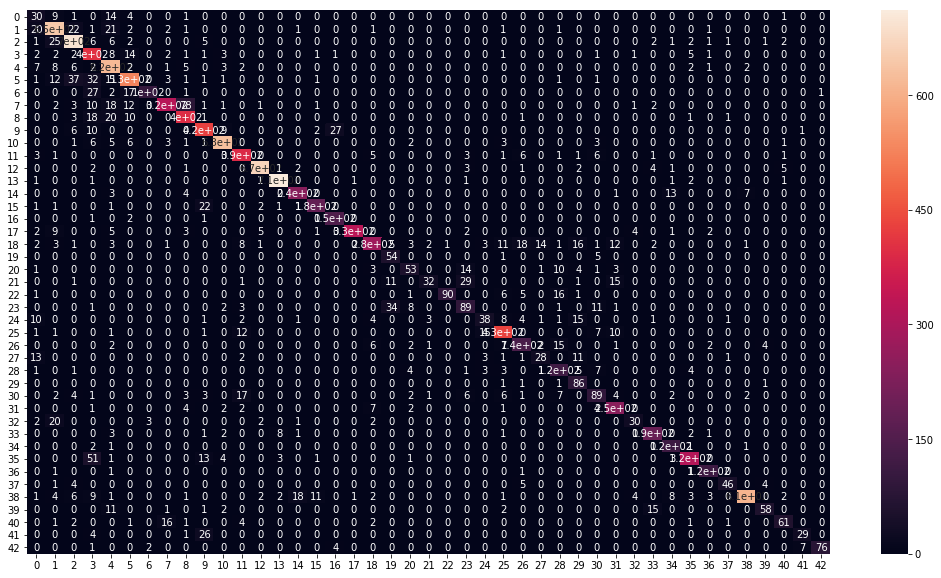

In [7]:
#get the predictions for the test data
predicted_classes = cnn_model.predict_classes(X_test_gray_norm)
#get the indices to be plotted
y_true = y_test

# Confusion Matrix (Sum the diagonal element to get the total true correct values)
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (18,10))
sns.heatmap(cm, annot=True)

# classifiation report
num_classes = 43
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names = target_names))

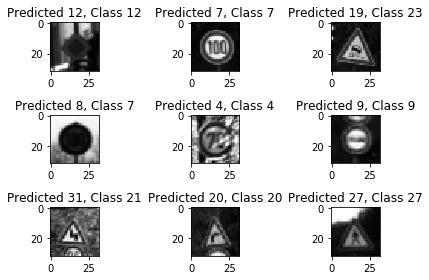

In [8]:
# Plot the predict vs true class for visulaizing purposes
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test_gray_norm[i+10].squeeze(), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[i+10], y_true[i+10]))
    plt.tight_layout()